In [6]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist

In [7]:
# Load images from folder (including subdirectories)
dataset_path = '/kaggle/input/number-plate-denoising/test/images'
def load_images_from_folder(folder):
    images = []
    for root, dirs, files in os.walk(folder):
        for filename in files:
            img_path = os.path.join(root, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
                img = cv2.resize(img, (64, 64))  # Resize to desired size
                images.append(img)
    return np.array(images)

x = load_images_from_folder(dataset_path)

In [8]:
x = x.astype('float32') / 255.0

# Add less noise to images
noise_factor = 0.3  # Adjusted noise factor
x_noisy = x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x.shape)
x_noisy = np.clip(x_noisy, 0., 1.)

In [10]:
x_train, x_test = train_test_split(x, test_size=0.2, random_state=42)  # 20% for testing
x_train_noisy, x_test_noisy = train_test_split(x_noisy, test_size=0.2, random_state=42)

# Reshape the data for the model
x_train_noisy = x_train_noisy.reshape(len(x_train_noisy), 64, 64, 1)
x_test_noisy = x_test_noisy.reshape(len(x_test_noisy), 64, 64, 1)

In [12]:

    model = keras.Sequential()

    # Encoder
    model.add(layers.Input(shape=(64, 64, 1)))  # Change to 1 channel for grayscale
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))

    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))

    # Decoder
    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))

    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))

    model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))  # Change to 1 channel for grayscale



In [17]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics =['accuracy'])

In [18]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,193 (47.63 KB)

 Trainable params: 12,193 (47.63 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train the autoencoder
model.fit(x_train_noisy, x_train,
                epochs=1,
                batch_size=128,
                validation_data=(x_test_noisy, x_test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.0014 - loss: 0.0231 - val_accuracy: 0.0038 - val_loss: 0.0805


In [20]:
denoised_images = model.predict(x_test_noisy)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


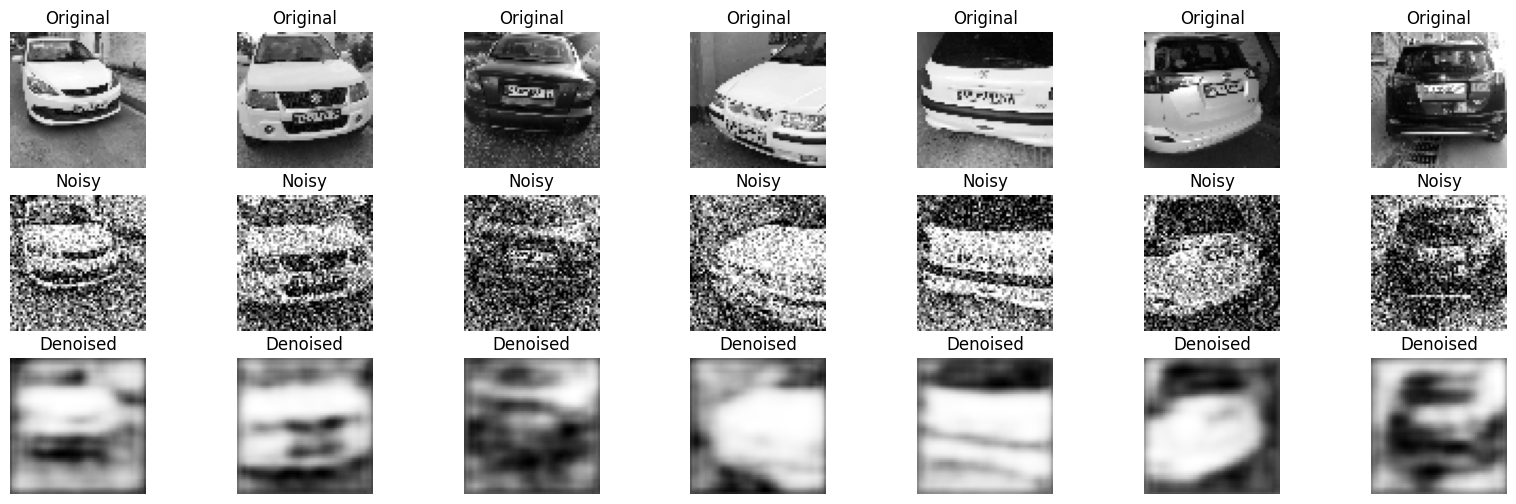

In [22]:
n = 7  # Number of images to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Original images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # Noisy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i], cmap='gray')
    plt.title("Noisy")
    plt.axis("off")

    # Denoised images
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(denoised_images[i].reshape(64, 64), cmap='gray')  # Reshape for display
    plt.title("Denoised")
    plt.axis("off")

plt.show()
